# Mount data 


In [ ]:
#!pip install kaggle
# this is to upgrade albumentations package in case error happens 
!pip install --upgrade git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-sv6veosa
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-sv6veosa
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=98755 sha256=7ea5818d4f76d798eeb23bae771630a12a71bfead8c9276da19f2804d9a67549
  Stored in directory: /tmp/pip-ephem-wheel-cache-u04hesw2/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/colab"


In [4]:
%cd /content/gdrive/My Drive/colab

[Errno 2] No such file or directory: '/content/gdrive/My Drive/colab'
/content


# Display RGB value for each class

In [ ]:
import pandas as pd 
label= pd.read_csv('/content/gdrive/MyDrive/colab CPS project/kaggle_drone/class_dict_seg.csv')
label 

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
col=[' r',' g',' b']
label_rgb=label[col].values.tolist()

In [ ]:
# store the RGB value in a list
label_rgb

[[0, 0, 0],
 [128, 64, 128],
 [130, 76, 0],
 [0, 102, 0],
 [112, 103, 87],
 [28, 42, 168],
 [48, 41, 30],
 [0, 50, 89],
 [107, 142, 35],
 [70, 70, 70],
 [102, 102, 156],
 [254, 228, 12],
 [254, 148, 12],
 [190, 153, 153],
 [153, 153, 153],
 [255, 22, 96],
 [102, 51, 0],
 [9, 143, 150],
 [119, 11, 32],
 [51, 51, 0],
 [190, 250, 190],
 [112, 150, 146],
 [2, 135, 115],
 [255, 0, 0]]

# import packages




In [5]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 6.4 MB/s 


In [6]:

import numpy as np
import os 
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# UNet model from: https://github.com/qubvel/segmentation_models
import segmentation_models as sm

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import keras
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img
from keras import utils

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model



Segmentation Models: using `keras` framework.


In [7]:
import albumentations as A

from sklearn.model_selection import train_test_split
#from tqdm.notebook import tqdm
#import helper
import time 
import glob 
 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
print(tf. __version__) 

2.5.0


# Resize the 6000x4000 image to 480x320 
# to reduce model fitting time

In [ ]:
# opencv resize 
'''
def resize (path,target_path):
    for filename in os.listdir(path):
        img=Image.open(os.path.join(path,filename))
        image=img.resize((480,320),Image.ANTIALIAS)
        image.save(target_path+'/'+filename)



resize('/content/gdrive/MyDrive/colab/kaggle_drone/train_original','/content/gdrive/MyDrive/colab/kaggle_drone/resize_train_original')
resize('/content/gdrive/MyDrive/colab/kaggle_drone/train_mask','/content/gdrive/MyDrive/colab/kaggle_drone/resize_train_mask')
'''

"\ndef resize (path,target_path):\n    for filename in os.listdir(path):\n        img=Image.open(os.path.join(path,filename))\n        image=img.resize((480,320),Image.ANTIALIAS)\n        image.save(target_path+'/'+filename)\n\n\n\nresize('/content/gdrive/MyDrive/colab/kaggle_drone/train_original','/content/gdrive/MyDrive/colab/kaggle_drone/resize_train_original')\nresize('/content/gdrive/MyDrive/colab/kaggle_drone/train_mask','/content/gdrive/MyDrive/colab/kaggle_drone/resize_train_mask')\n"

In [ ]:
# test image size 
img=Image.open('/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_test_original/565.jpg')
img.size 

(480, 320)

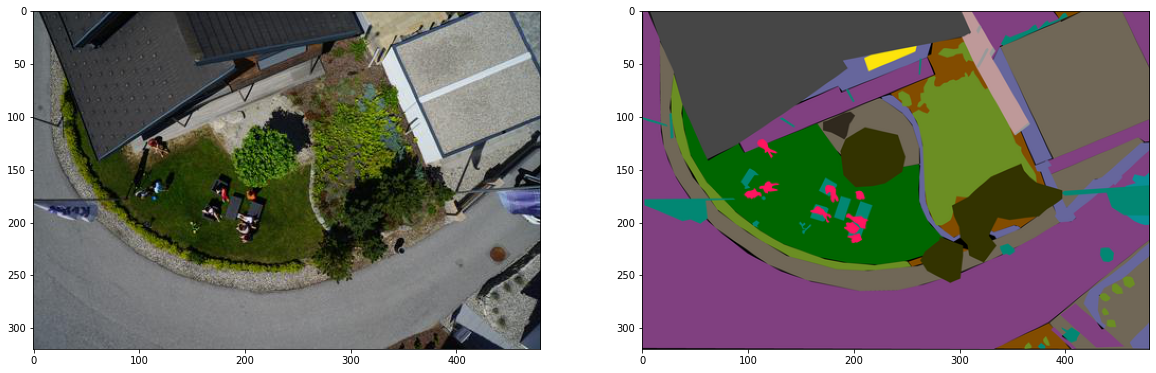

In [ ]:
# example display
org_img='/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_test_original/587.jpg'

mask_img='/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_test_mask/587.png'
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(20,10))

ax1.imshow(Image.open(org_img))

ax2.imshow(Image.open(mask_img))


# Path for resized image and mask

In [8]:

x_train_dir = '/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_train_original'
y_train_dir = '/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_train_mask'

x_valid_dir = '/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_val_original'
y_valid_dir = '/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_val_mask'


x_test_dir = '/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_test_original'
y_test_dir = '/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_test_mask'

# for doing test :
y_test_label_dir='/content/gdrive/MyDrive/colab CPS project/kaggle_drone/test_label '

# Extract labeled classes from the images 

In [ ]:
label["name"]

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

In [ ]:
# store all classes in CLASSES
CLASSES=[]
for item in label['name']:
    CLASSES.append(item)
CLASSES

['unlabeled',
 'paved-area',
 'dirt',
 'grass',
 'gravel',
 'water',
 'rocks',
 'pool',
 'vegetation',
 'roof',
 'wall',
 'window',
 'door',
 'fence',
 'fence-pole',
 'person',
 'dog',
 'car',
 'bicycle',
 'tree',
 'bald-tree',
 'ar-marker',
 'obstacle',
 'conflicting']

In [ ]:

classes= ['paved-area','person','tree','wall']
class_values = [CLASSES.index(cls.lower()) for cls in classes]
class_values
rgb=[label_rgb[i] for i in class_values]
rgb 


"\nclasses= ['paved-area','person','tree','wall']\nclass_values = [CLASSES.index(cls.lower()) for cls in classes]\nclass_values\nrgb=[label_rgb[i] for i in class_values]\nrgb \n"

# Functions acquired from github 

In [ ]:
# creating Dataset and Dataloader
class Dataset:

  # /content/gdrive/MyDrive/colab/kaggle_drone/train_original/000.jpg  
    CLASSES = CLASSES


    def __init__(self, images_dir,masks_dir,classes=None,augmentation=None,preprocessing=None):
            
        self.ids1 = os.listdir(images_dir)
        self.ids2= os.listdir(masks_dir)
        self.ids1.sort()
        self.ids2.sort()
        self.classes=classes 

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids1]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.ids2]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.masks_fps[i])
        mask= cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        
        # extract certain classes from mask (e.g. cars)
        semantic_map=[]
        for color in [label_rgb[index] for index in self.class_values]:
            equality = np.equal (mask,color)
            class_map=np.all(equality,axis=-1)
            semantic_map.append(class_map)
        mask=np.float32(np.stack(semantic_map, axis=-1))
        #print("class value is :",self.class_values)
        '''
        # akip the adding background method
        '''
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
           
        return image, mask
        
    def __len__(self):
        return len(self.ids1)

In [ ]:
class Dataloder(tf.keras.utils.Sequence):

    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # new keras need to return a tuple 
        
        return tuple(batch)


In [ ]:

def visualize(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

In [ ]:

def get_preprocessing(preprocessing_fn):

    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


def get_validation_augmentation():
  
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)


def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

In [ ]:
# test Dataset function 
dataset = Dataset(x_valid_dir, y_valid_dir, classes= CLASSES) 
img, mask =dataset[5]

mask.shape 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


(320, 480, 24)

Text(0.5, 1.0, 'mask')

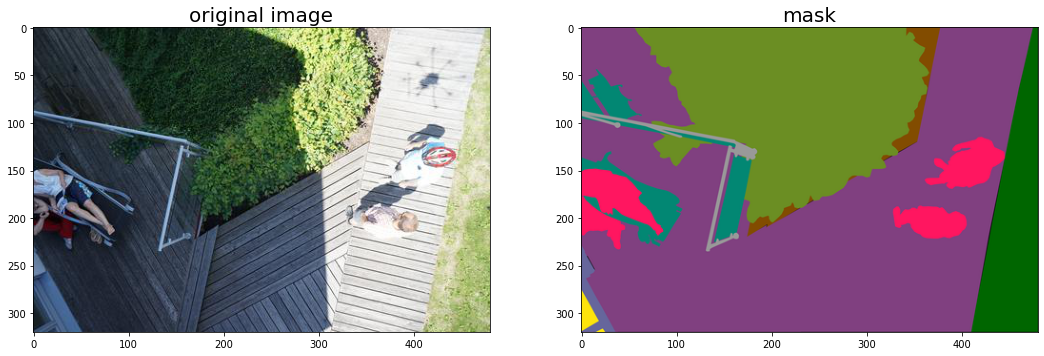

In [ ]:
#visualize 451.jpg 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,15))
plt.subplot(121)
plt.imshow(Image.open('/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_val_original/451.jpg'))
plt.title('original image',fontsize=20)
plt.subplot(122)
plt.imshow(Image.open('/content/gdrive/MyDrive/colab CPS project/kaggle_drone/resize_val_mask/451.png'))
plt.title('mask',fontsize=20)

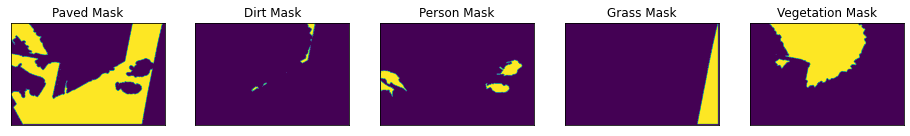

In [ ]:
# test visualiztion 
visualize(paved_mask=mask[:,:,1], dirt_mask=mask[:,:,2],person_mask=mask[...,15],grass_mask=mask[...,3],vegetation_mask=mask[...,8])

# Test on :combine several one-hot encoded imgs into one 

In [ ]:
label_rgb

[[0, 0, 0],
 [128, 64, 128],
 [130, 76, 0],
 [0, 102, 0],
 [112, 103, 87],
 [28, 42, 168],
 [48, 41, 30],
 [0, 50, 89],
 [107, 142, 35],
 [70, 70, 70],
 [102, 102, 156],
 [254, 228, 12],
 [254, 148, 12],
 [190, 153, 153],
 [153, 153, 153],
 [255, 22, 96],
 [102, 51, 0],
 [9, 143, 150],
 [119, 11, 32],
 [51, 51, 0],
 [190, 250, 190],
 [112, 150, 146],
 [2, 135, 115],
 [255, 0, 0]]

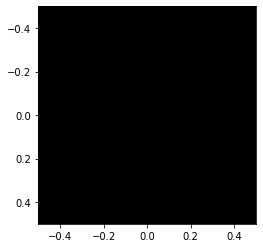

In [ ]:
plt.imshow([[label_rgb[0]]])

In [ ]:
def toimg(mask):
    pal={0:(0,0,0),1:(128, 64, 128),2:(130, 76, 0),3:(130, 76, 0),4:(0, 102, 0),5:(112, 103, 87)}
    rows=mask.shape[0]
    col=mask.shape[1]
    img=np.zeros((rows,col,3),dtype=np.uint8)
    for j in range(rows):
        for i in range(col):
            img[j,i]=pal[np.argmax(mask[j,i])]
    return img

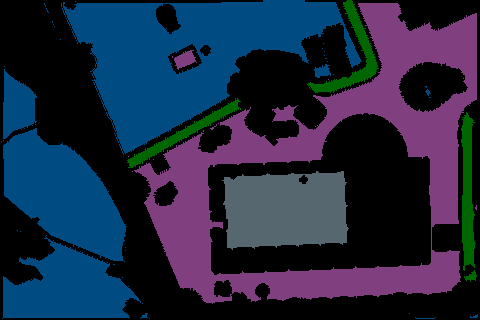

In [ ]:
img=toimg(mask)
cv2_imshow(img)

# Test on: img augmentation function

In [ ]:
np.array(CLASSES)

array(['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water',
       'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door',
       'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree',
       'bald-tree', 'ar-marker', 'obstacle', 'conflicting'], dtype='<U11')

In [ ]:
dataset1=Dataset(x_test_dir,y_test_dir,classes=['paved-area','dirt'],augmentation=get_training_augmentation())


[1, 2]


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

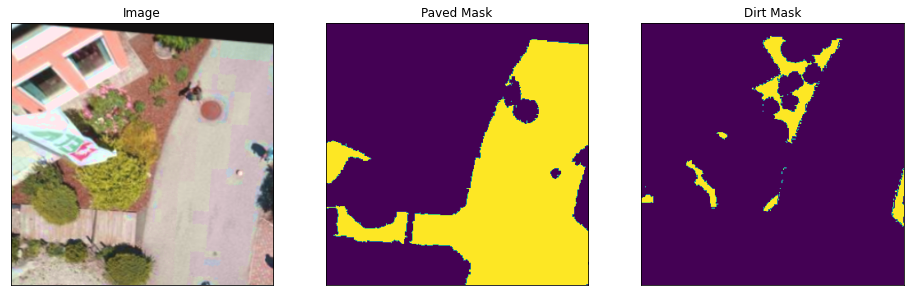

In [ ]:
img1,mask1= dataset1[0]
visualize(image=img1,paved_mask=mask1[:,:,0], dirt_mask=mask1[:,:,1])

In [ ]:
mask1.shape 

(320, 320, 2)

# Model fitting 


In [ ]:
#model parameters
EPOCHS=60
this_class= CLASSES     #, 'vegetation', 'roof', 'wall', 'window', 'door','fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree','bald-tree', 'ar-marker', 'obstacle']

miou_train=[0]*EPOCHS
miou_test=[0]*EPOCHS
mloss_train=[0]*EPOCHS
mloss_test=[0]*EPOCHS

BACKBONE =  'efficientnetb3' # 'resnet50'
LR = 0.0001
BATCH_SIZE=9
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:


# block parameters
n_classes = len(this_class)   # case for binary and multiclass segmentation  # remove '+1'
activation =  'softmax'

# model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)  #input shape

# optomizer
optim = keras.optimizers.Adam(LR)

 # loss function 
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss( )
total_loss = dice_loss + (1 * focal_loss)



metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


model.compile(optim, total_loss, metrics)

    # Dataset for train images
train_dataset = Dataset(
        x_train_dir, 
        y_train_dir, 
        classes=this_class, 
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input)
    )

    # Dataset for validation images
valid_dataset = Dataset(
        x_valid_dir,
        y_valid_dir,
        classes=this_class,
        ,
        preprocessing=get_preprocessing(preprocess_input)
    )

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)



    # define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
        keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
        keras.callbacks.ReduceLROnPlateau(),
]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

In [ ]:
# shape of input iamge 
train_dataset[0][0].shape 

(320, 320, 3)

In [ ]:
# model summary 
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 40) 1080        input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:


 # fit:
history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )
    #losses miou_train,miou_test,mloss_train,mloss_test
train_iou=history.history['iou_score']
val_iou=history.history['val_iou_score']
train_loss=history.history['loss']
val_loss=history.history['val_loss']

'''
miou_train= [ train_iou[i]+miou_train[i] for i in range( len(miou_train))]
miou_test= [ val_iou[i]+miou_test[i] for i in range( len(val_iou))]
mloss_train = [train_loss[i]+ mloss_train[i] for i in range( len(mloss_train))]
mloss_test= [val_loss[i]+ mloss_test[i] for i in range( len(mloss_test))]
'''



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
33/33 [==============================] - 77s 2s/step - loss: 1.0000 - iou_score: 0.0913 - f1-score: 0.0916 - val_loss: 1.0186 - val_iou_score: 0.4229 - val_f1-score: 0.4236
Epoch 2/50
33/33 [==============================] - 62s 2s/step - loss: 0.9793 - iou_score: 0.1519 - f1-score: 0.1578 - val_loss: 0.9800 - val_iou_score: 0.4795 - val_f1-score: 0.4864
Epoch 3/50
33/33 [==============================] - 62s 2s/step - loss: 0.9499 - iou_score: 0.2205 - f1-score: 0.2381 - val_loss: 0.9649 - val_iou_score: 0.5132 - val_f1-score: 0.5219
Epoch 4/50
33/33 [==============================] - 62s 2s/step - loss: 0.9237 - iou_score: 0.2438 - f1-score: 0.2715 - val_loss: 0.9385 - val_iou_score: 0.5882 - val_f1-score: 0.6030
Epoch 5/50
33/33 [==============================] - 62s 2s/step - loss: 0.9008 - iou_score: 0.2678 - f1-score: 0.3013 - val_loss: 0.9234 - val_iou_score: 0.5889 - val_f1-score: 0.6033
Epoch 6/50
33/33 [==============================] - 61s 2s/step - loss: 0.8868 -

In [ ]:
miou_train.shape 
x=np.arange(1,41)
x 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

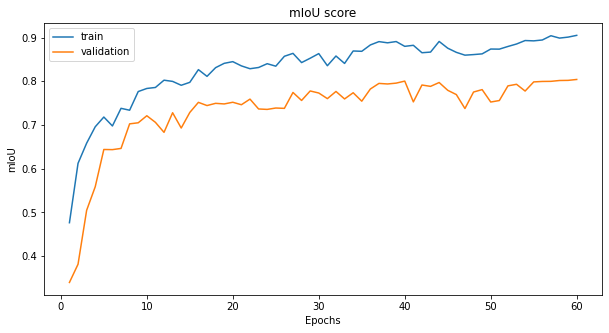

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x,miou_train)
plt.plot(x,miou_test)
plt.title('mIoU score')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend(['train','validation'])

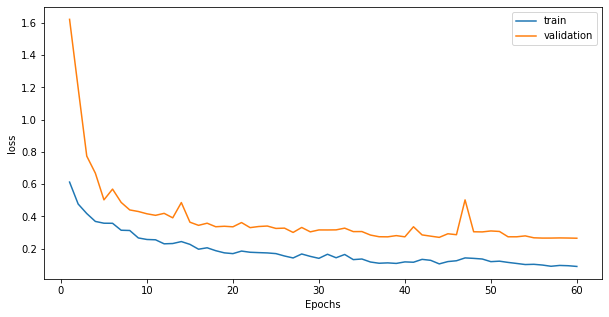

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x,mloss_train)
plt.plot(x,mloss_test)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])

# Evaluation on test set 

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES , 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

#evaluate
scores = model.evaluate_generator(test_dataloader)

print("Loss:",scores[0])
print ('mIoU',scores[2])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.7820031046867371
mIoU 0.6685265302658081


In [ ]:
scores 

[2.560617685317993, 0.07470383495092392, 0.08170294761657715]

In [ ]:
this_class

['paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool']

# Predict img 565.jpg from the test set 


In [ ]:
from skimage import io

def predict_mask(path):
    file=path
    img = io.imread(file) # novel image
    img= cv2.resize(img,(480,320))
    img = preprocess_input(img) # use the preprocessing input method based on the backbone you used
    mask = model.predict(np.expand_dims(img, axis = 0)).squeeze() # change the shape to (1 H, W)

    mask=np.argmax(mask,axis=-1) # size of (H, W)
    
    return mask

In [ ]:
# resize (WxH) images to (WxHxC) RGB images congruent with class RBG values in 'pal'  
def convertToRGB(mask):
    target_mask= np.zeros((320,480,3),dtype=np.uint8)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            number=mask[i][j]
            target_mask[i][j]=np.array(pal[number])
    return target_mask 

In [ ]:
pal={0:(0,0,0),1:(128, 64, 128),2:(130, 76, 0),3:(0, 102, 0),4:(112, 103, 87),5:(28, 42, 168),6:(48, 41, 30),7:(0, 50, 89),
     8:(107, 142, 35),9:(70, 70, 70),10:(102, 102, 156),11:(254, 228, 12),12:(254, 148, 12),13:(190, 153, 153),14:(153, 153, 153),
     15:(255, 22, 96),16:(102, 51, 0),17:(9, 143, 150),18:(119, 11, 32),19:(51, 51, 0),20:(190, 250, 190),21:(112, 150, 146),
     22:(2, 135, 115),23:(255, 0, 0) }


In [ ]:
# make sure it has converted into RGB channel mask
target_565 =convertToRGB(pre_565_mask)
target_565.shape 

(320, 480, 3)

In [ ]:
# original pic 
def predict_visualization (img_path,mask_path,target_mask):
    fig, ax = plt.subplots(1,3,figsize=(18,15))
    
    plt.subplot(131)
    plt.axis('off')
    plt.title('original image',fontsize=15)
    plt.imshow(Image.open(img_path))

    plt.subplot(132)
    plt.axis('off')
    plt.title('ground_truth mask',fontsize=15)
    plt.imshow(Image.open(mask_path))

    plt.subplot(133)
    plt.title('predicted mask',fontsize=15)
    plt.imshow(target_mask)
    plt.axis("off")



In [ ]:

def display_original_mask_target ( img_number):
    img_path=os.path.join(x_test_dir+'/'+img_number+'.jpg')
    mask_path=os.path.join(y_test_dir+'/'+img_number+'.png')
    target_mask= predict_mask(img_path)
    target_mask= convertToRGB(target_mask)
    predict_visualization(img_path,mask_path,target_mask)

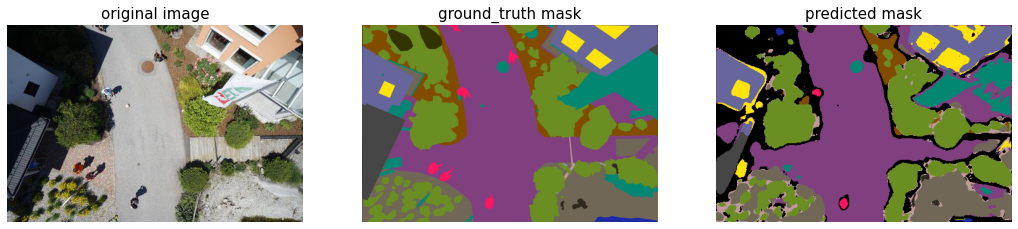

In [ ]:
# 565.jpg 
display_original_mask_target('565')

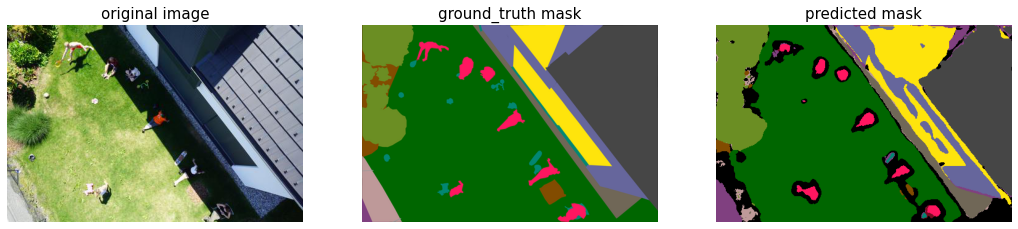

In [ ]:
# 566.jpg 
display_original_mask_target('566')

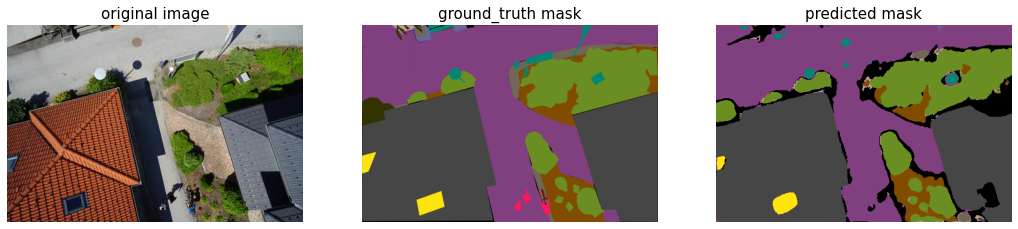

In [ ]:
# 567.jpg 
display_original_mask_target('567')

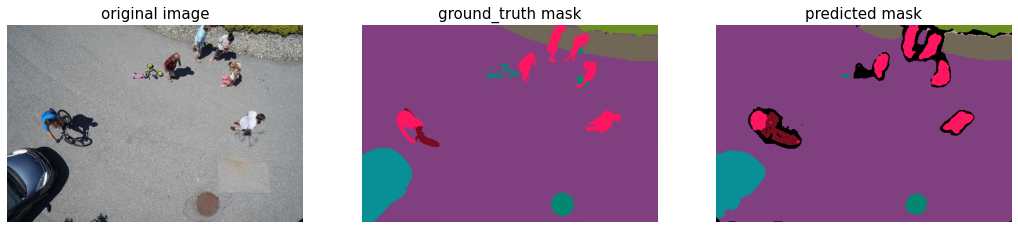

In [ ]:
# 568.jpg 
display_original_mask_target('568')

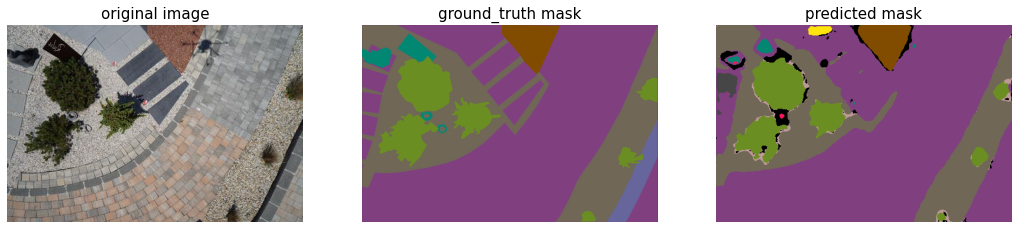

In [ ]:
# 569.jpg 
display_original_mask_target('569')

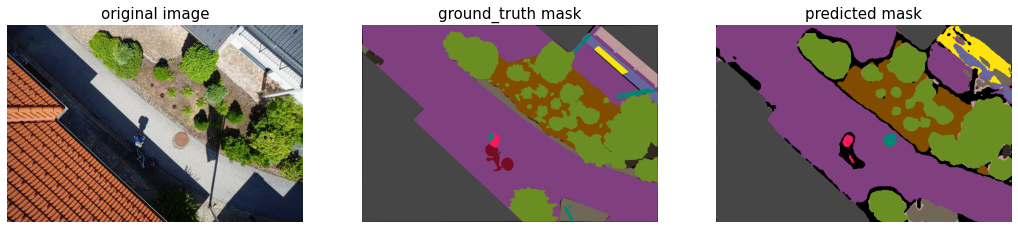

In [ ]:
# 570.jpg 
display_original_mask_target('570')

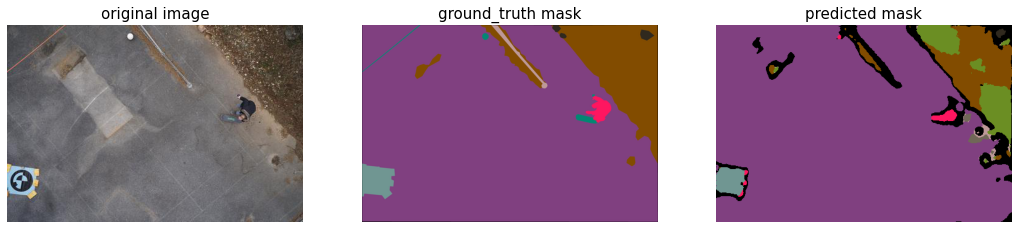

In [ ]:
# 573.jpg 
display_original_mask_target('573')

# Predict image from google map bird eye view 

(-0.5, 1066.5, 697.5, -0.5)

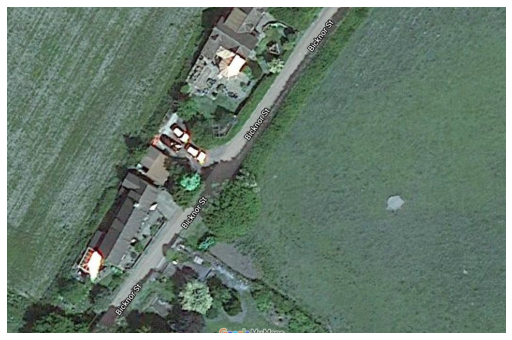

In [9]:
google_file='/content/gdrive/MyDrive/colab CPS project/kaggle_drone/google_map_pic/2.jpg'
file=cv2.imread(google_file)
plt.figure(figsize=(9,6))
plt.imshow(file)
plt.axis('off')


In [ ]:
pr_google_pic= predict_mask(path='/content/gdrive/MyDrive/colab CPS project/kaggle_drone/google_map_pic/2.jpg')
pr_google_pic= convertToRGB(pr_google_pic)
pr_google_pic.shape

(320, 480, 3)

(-0.5, 479.5, 319.5, -0.5)

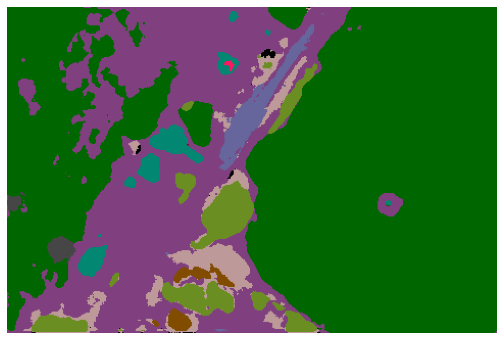

In [ ]:
# predicted mask 
plt.figure(figsize=(9,6))
plt.imshow(pr_google_pic)
plt.axis('off')
